Label Distribution:
0 429
1 152



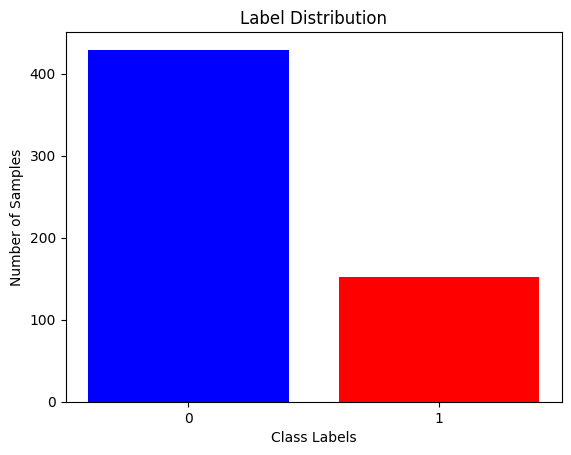

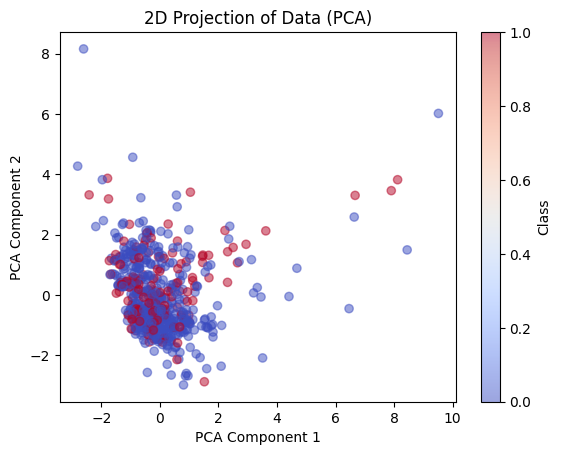

SVM - Full Feature Set
Accuracy 0.6324786324786325
Precision 0.3695652173913043
Recall 0.5483870967741935

Logistic Regression - Full Feature Set
Accuracy 0.6239316239316239
Precision 0.3617021276595745
Recall 0.5483870967741935

Random Forest - Full Feature Set
Accuracy 0.7264957264957265
Precision 0.4878048780487805
Recall 0.6451612903225806

Decision Tree - Full Feature Set
Accuracy 0.6239316239316239
Precision 0.37735849056603776
Recall 0.6451612903225806

SVM - Reduced Feature Set
Accuracy 0.5042735042735043
Precision 0.30985915492957744
Recall 0.7096774193548387

Logistic Regression - Reduced Feature Set
Accuracy 0.5897435897435898
Precision 0.34545454545454546
Recall 0.6129032258064516

Random Forest - Reduced Feature Set
Accuracy 0.7435897435897436
Precision 0.5128205128205128
Recall 0.6451612903225806

Decision Tree - Reduced Feature Set
Accuracy 0.6068376068376068
Precision 0.3584905660377358
Recall 0.6129032258064516

SVM - Expanded Feature Set
Accuracy 0.5641025641025641
Pr

In [ ]:
#This script was helded with ChatGPT (OpenAI, 2025).

#Author: Corey Zhang
#Date: 3/20/2025
#Source: OpenAI ChatGPT


import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE


tweet_feature_path = "tweet_feature"
labeled_tweets_path = "labeled_tweets.txt"

# Load labels
label_dic = {}
with open(labeled_tweets_path, "r", encoding="utf-8", errors="ignore") as file_label_in:
    for label_line in file_label_in:
        label_line_split = label_line.strip().split("\t")
        label_tweet_id = label_line_split[0]
        label_dic[label_tweet_id] = int(label_line_split[-1])

# Load features
dataset_X = []
dataset_y = []
with open(tweet_feature_path, "r", encoding="utf-8", errors="ignore") as file_feature_in:
    next(file_feature_in)  # Skip header line
    for feature_line in file_feature_in:
        feature_line_split = feature_line.strip().split("\t")
        feature_tweet_id = feature_line_split[0]
        if feature_tweet_id in label_dic.keys():
            dataset_X.append([float(i) for i in feature_line_split[2:]])  # Exclude ID columns
            dataset_y.append(label_dic[feature_tweet_id])


dataset_X = np.array(dataset_X)
dataset_y = np.array(dataset_y)

# Check label distribution
unique_classes, class_counts = np.unique(dataset_y, return_counts=True)
print("Label Distribution:")
for cls, count in zip(unique_classes, class_counts):
    print(cls, count)
print()

# plot distribution
plt.bar(unique_classes.astype(str), class_counts, color=["blue", "red"])
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Label Distribution")
plt.show()

# Ensure at least two unique classes
if len(unique_classes) < 2:
    raise ValueError("Target variable `dataset_y` has only one class! Choose another target.")

# Scale features
scaler = StandardScaler()
dataset_X = scaler.fit_transform(dataset_X)

# **PCA Visualization**
pca = PCA(n_components=2)
X_pca = pca.fit_transform(dataset_X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dataset_y, cmap="coolwarm", alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Projection of Data (PCA)")
plt.colorbar(label="Class")
plt.show()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    dataset_X, dataset_y, test_size=0.20, random_state=42, stratify=dataset_y
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# **Define feature transformations (Apply SAME transformations to Test Set!)**
def get_feature_set(X_train, X_test, feature_type):
    if feature_type == "Reduced Feature Set":
        return X_train[:, :5], X_test[:, :5]  # Select first 5 features
    elif feature_type == "Expanded Feature Set":
        return np.hstack([X_train, X_train**2]), np.hstack([X_test, X_test**2])  # Add interaction terms
    else:
        return X_train, X_test  # Use full feature set

# different feature sets**
feature_types = ["Full Feature Set", "Reduced Feature Set", "Expanded Feature Set"]
models = {
    "SVM": SVC(C=1, kernel="linear", class_weight="balanced"),
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=7, class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=4, class_weight="balanced", random_state=42),
}

# Store results
feature_results = []

for feature_type in feature_types:
    X_train_set, X_test_set = get_feature_set(X_train, X_test, feature_type)

    for model_name, model in models.items():
        model.fit(X_train_set, y_train)
        y_pred = model.predict(X_test_set)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="binary", zero_division=1)
        recall = recall_score(y_test, y_pred, average="binary", zero_division=1)

        print(model_name, "-", feature_type)
        print("Accuracy", accuracy)
        print("Precision", precision)
        print("Recall", recall)
        print()

        feature_results.append([model_name, feature_type, accuracy, precision, recall])

        # Save trained models
        save_model_path = f"{model_name.replace(' ', '_')}_{feature_type.replace(' ', '_')}.pkl"
        with open(save_model_path, "wb") as model_file:
            pickle.dump(model, model_file)

# Save results
with open("model_performance_results.txt", "w") as f:
    for row in feature_results:
        f.write(" ".join(map(str, row)) + "\n")
